In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns

df = pd.read_csv('AmesHousing.csv', sep='\t')
pd.set_option('display.max_columns', None)
new_df = df.assign(hasBasement = df['Total Bsmt SF'] > 0)
new_df = new_df.assign(hasGarage = df['Garage Area'] > 0)
new_df = new_df.assign(hasFireplace = df['Fireplaces'] > 0)
new_df = new_df.assign(hasPool = df['Pool Area'] > 0)
new_df = new_df.assign(TotalSF = (df['Total Bsmt SF'].fillna(0) + df['Gr Liv Area'].fillna(0)))
new_df = new_df.assign(TotalBath = (df['Bsmt Full Bath'].fillna(0) + 0.5 * df['Bsmt Half Bath'].fillna(0) + 
                                    df['Full Bath'].fillna(0) + 0.5 * df['Half Bath'].fillna(0)))
new_df = new_df.assign(TotalPorchSF = df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
new_df = new_df.assign(Positive_Off_Site = (df['Condition 2'] == 'PosN') | (df['Condition 2'] == 'PosA'))
new_df = new_df.assign(hasFence = df['Fence'].notnull())
new_df.drop(columns=['Total Bsmt SF', 'Fireplaces',
                      'Pool Area', 'Bsmt Exposure', 'Bsmt Half Bath',
                        'Bsmt Full Bath', 'BsmtFin Type 1', 'BsmtFin Type 2',
                          'Bsmt Exposure', 'Lot Config', 'Condition 2',
                            'Garage Type', 'Garage Finish', 'Garage Qual',
                              'Pool QC', 'Fence', 'Lot Shape', 'Land Slope',
                                'Fireplace Qu', 'Yr Sold',
                                  'Mo Sold', 'Order', '1st Flr SF', '2nd Flr SF'
                                  , 'Garage Yr Blt', 'Garage Cond', 'Wood Deck SF'
                                  , 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
                                  'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF', 'PID']
                                    ,inplace=True)
new_df = new_df[new_df['Electrical'].notnull()]

print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2929 entries, 0 to 2929
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2929 non-null   int64  
 1   MS Zoning          2929 non-null   object 
 2   Lot Frontage       2439 non-null   float64
 3   Lot Area           2929 non-null   int64  
 4   Street             2929 non-null   object 
 5   Alley              198 non-null    object 
 6   Land Contour       2929 non-null   object 
 7   Utilities          2929 non-null   object 
 8   Neighborhood       2929 non-null   object 
 9   Condition 1        2929 non-null   object 
 10  Bldg Type          2929 non-null   object 
 11  House Style        2929 non-null   object 
 12  Overall Qual       2929 non-null   int64  
 13  Overall Cond       2929 non-null   int64  
 14  Year Built         2929 non-null   int64  
 15  Year Remod/Add     2929 non-null   int64  
 16  Roof Style         2929 non-n

In [2]:
def categorize_price(price):
    if price < 100000:
        return 'Low'
    elif price < 175000:
        return 'Medium-Low'
    elif price < 300000:
        return 'Medium-High'
    else:
        return 'High'

new_df['PriceCategory'] = new_df['SalePrice'].apply(categorize_price)
print(new_df['PriceCategory'].value_counts().sort_index())

PriceCategory
High            238
Low             237
Medium-High    1002
Medium-Low     1452
Name: count, dtype: int64


In [3]:
X = new_df.drop(columns=['SalePrice', 'PriceCategory'])
y = new_df['PriceCategory']


ordinal_features = ['Utilities', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC','Kitchen Qual', 'Functional',
                    'Paved Drive']

nominal_features =['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style',
                   'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Misc Feature', 'Sale Type', 'Sale Condition', 'Electrical']


X_cat = X.copy()
bool_cols = X_cat.select_dtypes(include=['bool']).columns
X_cat[bool_cols] = X_cat[bool_cols].astype('object')

label_encoders = {}
for col in ordinal_features:
    if col in X_cat.columns:
        le = LabelEncoder()
        X_cat[col] = le.fit_transform(X_cat[col].astype(str))
        label_encoders[col] = le

nominal_present = [c for c in nominal_features if c in X_cat.columns]


if len(nominal_present) > 0:
    X_cat[nominal_present] = X_cat[nominal_present].astype(str)
    X_nominal_dummies = pd.get_dummies(X_cat[nominal_present], prefix=nominal_present)
    X_cat = X_cat.drop(columns=nominal_present)
    X_processed = pd.concat([X_cat, X_nominal_dummies], axis=1)
else:
    X_processed = X_cat.copy()

if len(bool_cols) > 0:
    X_processed[bool_cols] = X_processed[bool_cols].astype(int)


X = X_processed

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print(f"Class labels: {y_encoder.classes_}")


Number of features: 209
Number of classes: 4
Class labels: ['High' 'Low' 'Medium-High' 'Medium-Low']


In [4]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Scaled dataset shape:", X_scaled.shape)
print(X_scaled.describe())


Scaled dataset shape: (2929, 209)
       Lot Frontage     Lot Area    Utilities  Overall Qual  Overall Cond  \
count   2439.000000  2929.000000  2929.000000   2929.000000   2929.000000   
mean       0.165147     0.041357     0.000854      0.666515      0.570417   
std        0.080034     0.036838     0.027708      0.161423      0.138960   
min        0.000000     0.000000     0.000000      0.000000      0.000000   
25%        0.126712     0.028699     0.000000      0.555556      0.500000   
50%        0.160959     0.038019     0.000000      0.666667      0.500000   
75%        0.202055     0.047938     0.000000      0.777778      0.625000   
max        1.000000     1.000000     1.000000      1.000000      1.000000   

        Year Built  Year Remod/Add  Mas Vnr Area   Exter Qual   Exter Cond  \
count  2929.000000     2929.000000   2906.000000  2929.000000  2929.000000   
mean      0.719888        0.570980      0.063707     0.842950     0.927450   
std       0.219158        0.347660    

In [5]:

X_scaled['Lot Frontage'] = X_scaled['Lot Frontage'].fillna(0)
X_scaled['Mas Vnr Area'] = X_scaled['Mas Vnr Area'].fillna(0)
X_scaled['Garage Area'] = X_scaled['Garage Area'].fillna(0)
X_scaled['Garage Cars'] = X_scaled['Garage Cars'].fillna(0)
X_scaled.isna().sum()[X_scaled.isna().sum() > 0]

Series([], dtype: int64)

In [6]:
from sklearn.decomposition import PCA

pca_98 = PCA(n_components=0.98)
X_pca_98 = pca_98.fit_transform(X_scaled)

explained_ratios = pca_98.explained_variance_ratio_
for i, ratio in enumerate(explained_ratios):
    print(f"PC{i+1}: {ratio:.5f}")


PC1: 0.14065
PC2: 0.08512
PC3: 0.05990
PC4: 0.04596
PC5: 0.03946
PC6: 0.03312
PC7: 0.03080
PC8: 0.02984
PC9: 0.02681
PC10: 0.02512
PC11: 0.02233
PC12: 0.02136
PC13: 0.01935
PC14: 0.01665
PC15: 0.01625
PC16: 0.01532
PC17: 0.01413
PC18: 0.01326
PC19: 0.01262
PC20: 0.01238
PC21: 0.01161
PC22: 0.01115
PC23: 0.01073
PC24: 0.01039
PC25: 0.00988
PC26: 0.00950
PC27: 0.00946
PC28: 0.00880
PC29: 0.00822
PC30: 0.00786
PC31: 0.00761
PC32: 0.00696
PC33: 0.00671
PC34: 0.00620
PC35: 0.00617
PC36: 0.00600
PC37: 0.00587
PC38: 0.00561
PC39: 0.00528
PC40: 0.00508
PC41: 0.00492
PC42: 0.00480
PC43: 0.00458
PC44: 0.00454
PC45: 0.00443
PC46: 0.00435
PC47: 0.00429
PC48: 0.00424
PC49: 0.00414
PC50: 0.00395
PC51: 0.00385
PC52: 0.00378
PC53: 0.00355
PC54: 0.00344
PC55: 0.00339
PC56: 0.00324
PC57: 0.00315
PC58: 0.00299
PC59: 0.00285
PC60: 0.00283
PC61: 0.00276
PC62: 0.00271
PC63: 0.00258
PC64: 0.00250
PC65: 0.00244
PC66: 0.00235
PC67: 0.00229
PC68: 0.00226
PC69: 0.00211
PC70: 0.00202
PC71: 0.00199
PC72: 0.00190
P

In [7]:
print("Number of principal components for 98% variance:", pca_98.n_components_)


Number of principal components for 98% variance: 102


In [8]:
pca_full = PCA().fit(X_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
def components_for_threshold(threshold):
    return np.argmax(cumulative_variance >= threshold) + 1

components_95 = components_for_threshold(0.95)
components_90 = components_for_threshold(0.90)
components_80 = components_for_threshold(0.80)

components = [102, components_95, components_90, components_80]

print("Components needed for 95% variance:", components_95)
print("Components needed for 90% variance:", components_90)
print("Components needed for 80% variance:", components_80)



Components needed for 95% variance: 75
Components needed for 90% variance: 55
Components needed for 80% variance: 34


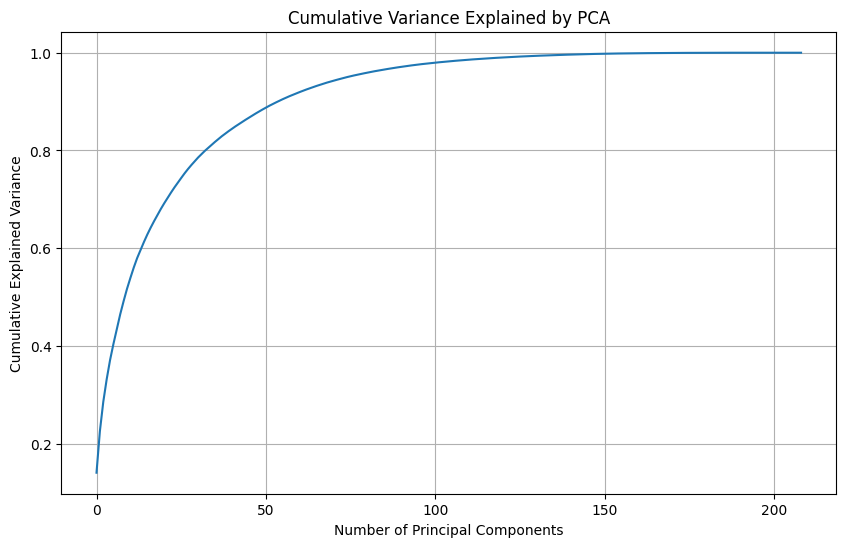

In [9]:
plt.figure(figsize=(10,6))
plt.plot(cumulative_variance)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Variance Explained by PCA")
plt.grid(True)
plt.show()


In [10]:
best_k_for_variance = {}
def elbow_silluette_plot(k_min=2, k_max=12):
    var_thresholds = [0.98, 0.95, 0.90, 0.80, 0.50]

    for var_thresh in var_thresholds:
        print(f"\nVariance threshold: {var_thresh*100:.0f}%")
        
        pca = PCA(n_components=var_thresh, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        
        inertias = []
        k_values = list(range(k_min, k_max+1))
        for k in k_values:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            km.fit(X_pca)
            inertias.append(km.inertia_)
        
        plt.figure(figsize=(6,4))
        plt.plot(k_values, inertias, 'o-', linewidth=2)
        plt.xlabel("Number of clusters k")
        plt.ylabel("Inertia (Sum of squared distances)")
        plt.title(f"Elbow Plot (Var {int(var_thresh*100)}%)")
        plt.grid(True)
        plt.show()

        elbow_candidates = list(range(5, k_max+1))

        sil_scores = []
        for k in elbow_candidates:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = km.fit_predict(X_pca)
            sil_scores.append(silhouette_score(X_pca, labels))
        
        best_k = elbow_candidates[np.argmax(sil_scores)]
        print(f"Best k for silhouette: {best_k}")
        
        km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        labels = km.fit_predict(X_pca)
        sample_sil = silhouette_samples(X_pca, labels)
        sil_avg = silhouette_score(X_pca, labels)
        
        fig, ax = plt.subplots(figsize=(7,4))
        y_lower = 10
        for cluster_id in range(best_k):
            vals = sample_sil[labels == cluster_id]
            vals.sort()
            size_i = vals.shape[0]
            y_upper = y_lower + size_i
            color = cm.nipy_spectral(float(cluster_id) / best_k)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, vals,
                            facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + size_i*0.5, str(cluster_id))
            y_lower = y_upper + 10
        ax.axvline(sil_avg, color="red", linestyle="--")
        ax.set_title(f"Silhouette Plot (k={best_k}, Var={int(var_thresh*100)}%, Score={sil_avg:.3f})")
        ax.set_xlabel("Silhouette Value")
        ax.set_yticks([])
        plt.tight_layout()
        plt.show()
        if best_k_for_variance.get(var_thresh) is None or best_k_for_variance[var_thresh] <= best_k:
            best_k_for_variance[var_thresh] = best_k
        print(best_k_for_variance)
            



Variance threshold: 98%


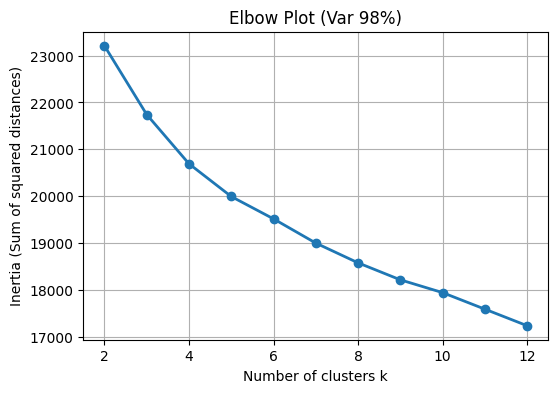

Best k for silhouette: 12


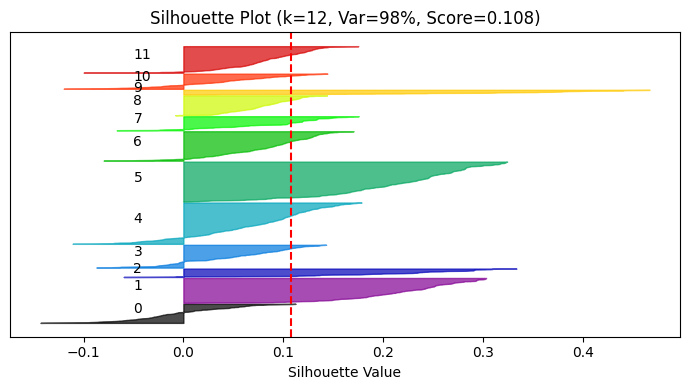

{0.98: 12}

Variance threshold: 95%


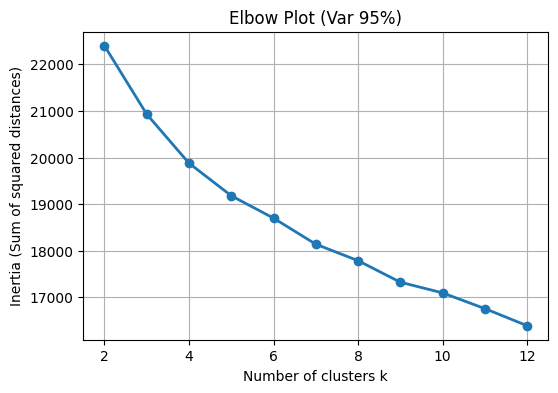

Best k for silhouette: 7


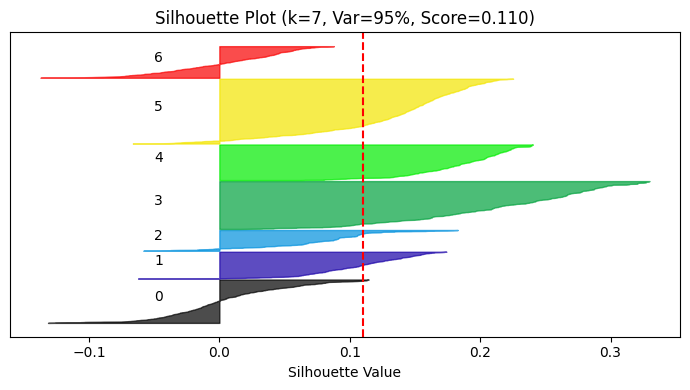

{0.98: 12, 0.95: 7}

Variance threshold: 90%


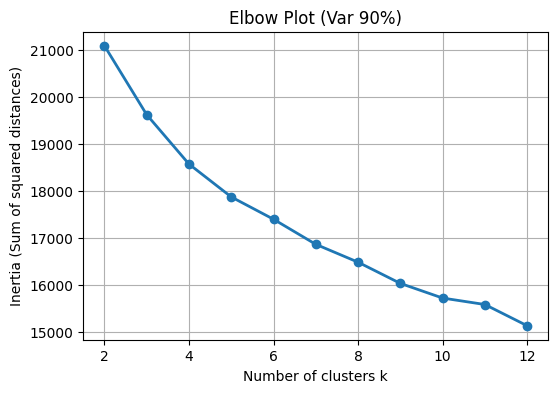

Best k for silhouette: 7


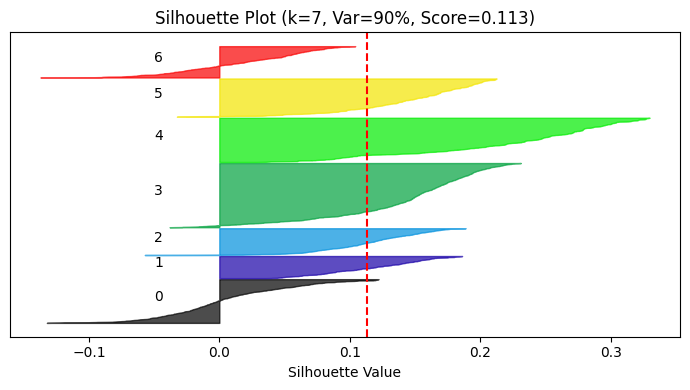

{0.98: 12, 0.95: 7, 0.9: 7}

Variance threshold: 80%


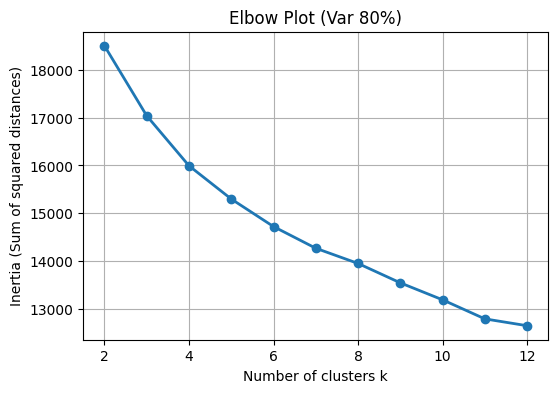

Best k for silhouette: 7


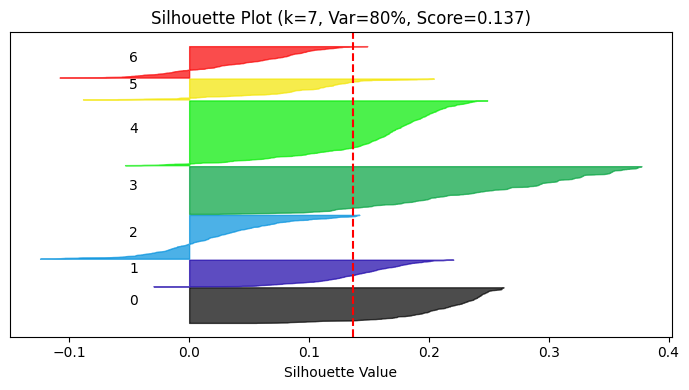

{0.98: 12, 0.95: 7, 0.9: 7, 0.8: 7}

Variance threshold: 50%


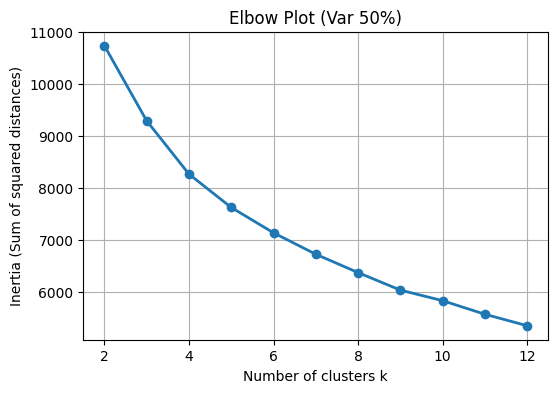

Best k for silhouette: 6


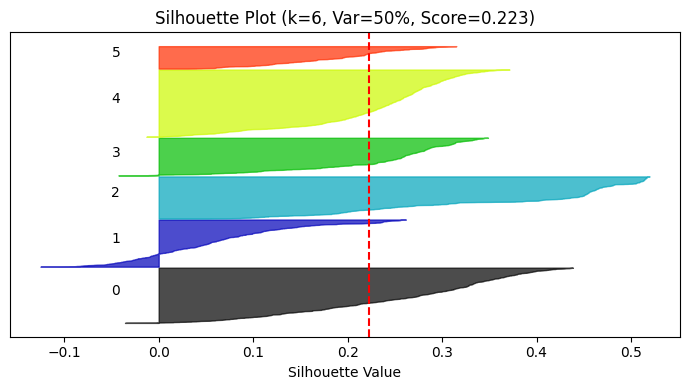

{0.98: 12, 0.95: 7, 0.9: 7, 0.8: 7, 0.5: 6}


In [11]:
elbow_silluette_plot()


Variance threshold: 98%


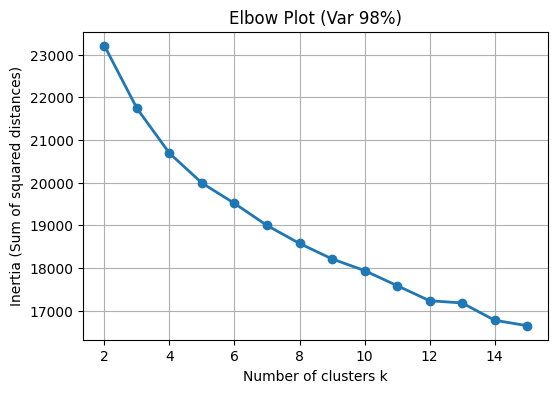

Best k for silhouette: 12


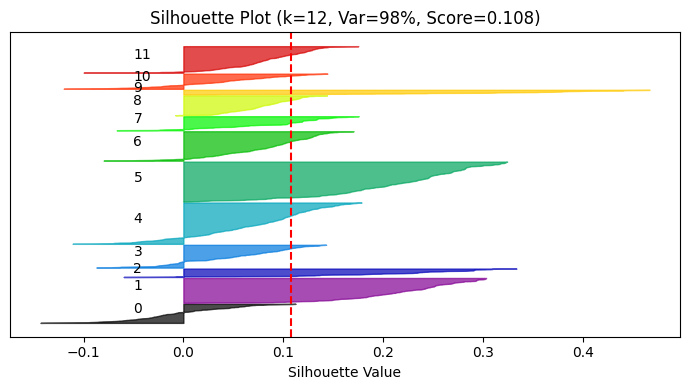

{0.98: 12, 0.95: 7, 0.9: 7, 0.8: 7, 0.5: 6}

Variance threshold: 95%


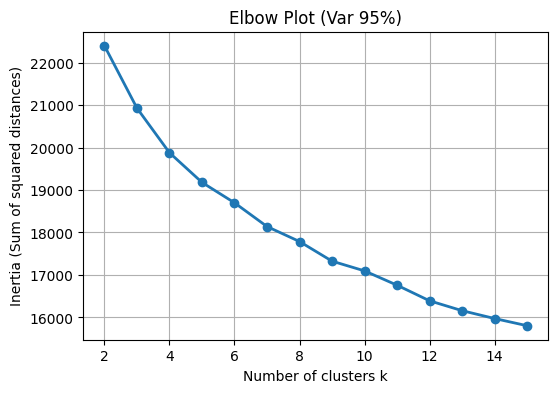

Best k for silhouette: 14


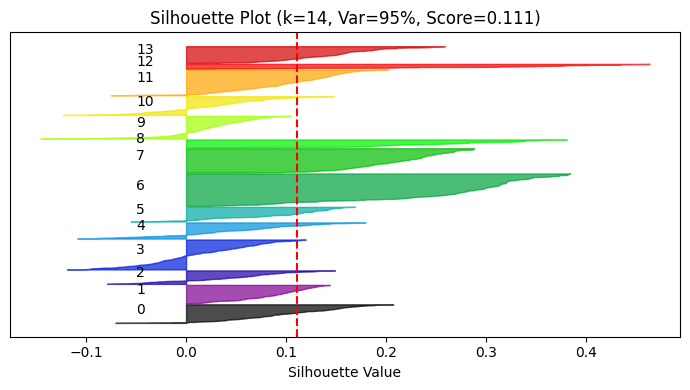

{0.98: 12, 0.95: 14, 0.9: 7, 0.8: 7, 0.5: 6}

Variance threshold: 90%


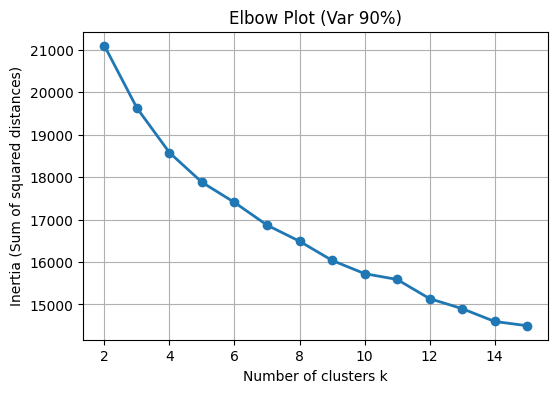

Best k for silhouette: 13


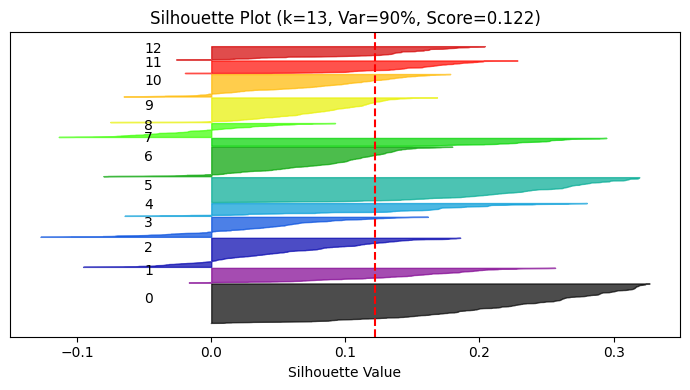

{0.98: 12, 0.95: 14, 0.9: 13, 0.8: 7, 0.5: 6}

Variance threshold: 80%


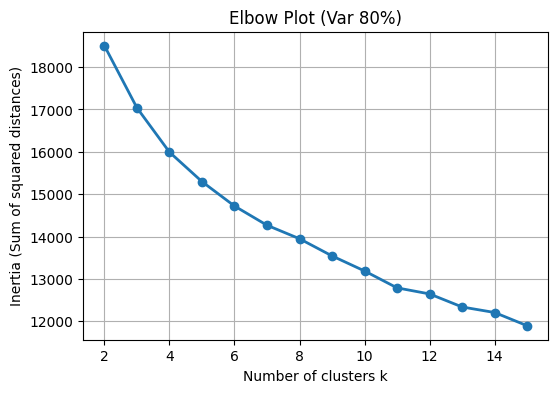

Best k for silhouette: 7


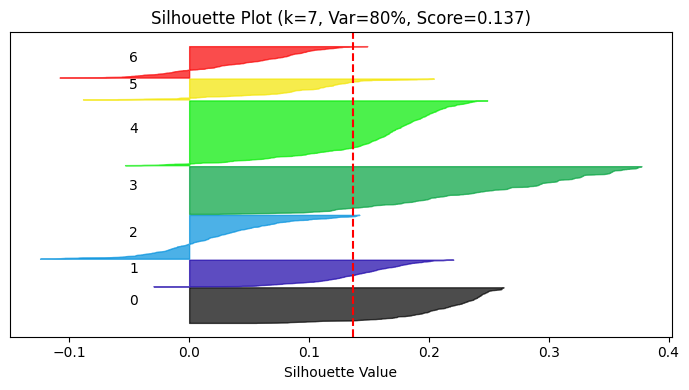

{0.98: 12, 0.95: 14, 0.9: 13, 0.8: 7, 0.5: 6}

Variance threshold: 50%


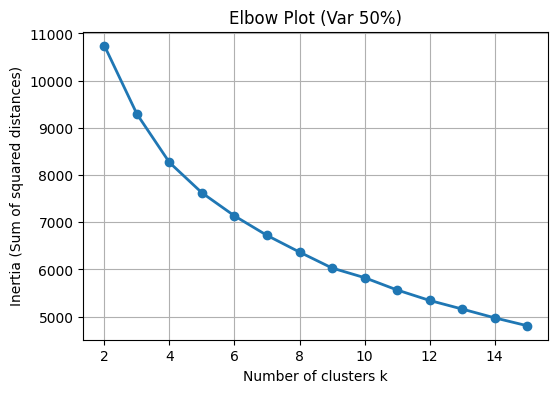

Best k for silhouette: 6


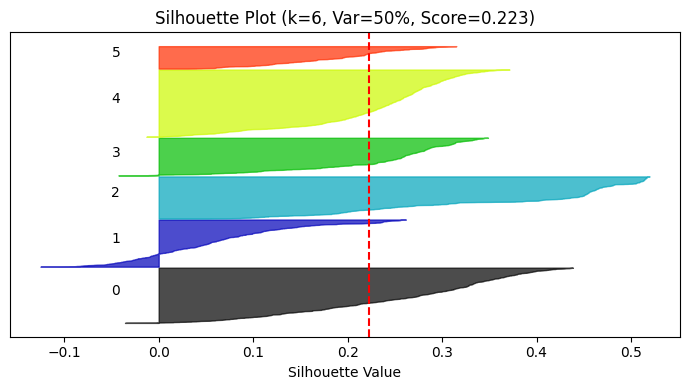

{0.98: 12, 0.95: 14, 0.9: 13, 0.8: 7, 0.5: 6}


In [12]:
elbow_silluette_plot(2, 15)


Variance threshold: 98%


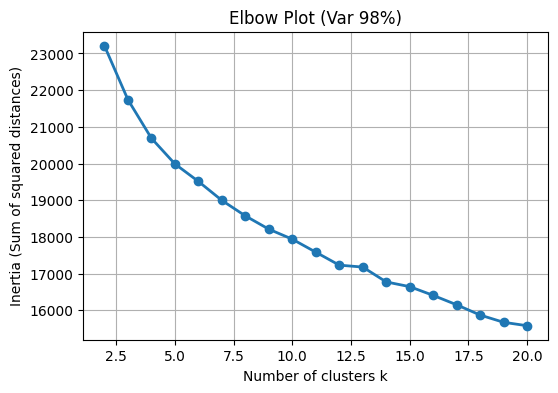

Best k for silhouette: 19


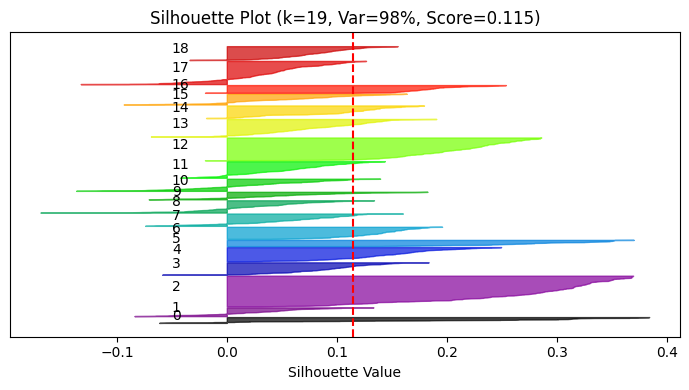

{0.98: 19, 0.95: 14, 0.9: 13, 0.8: 7, 0.5: 6}

Variance threshold: 95%


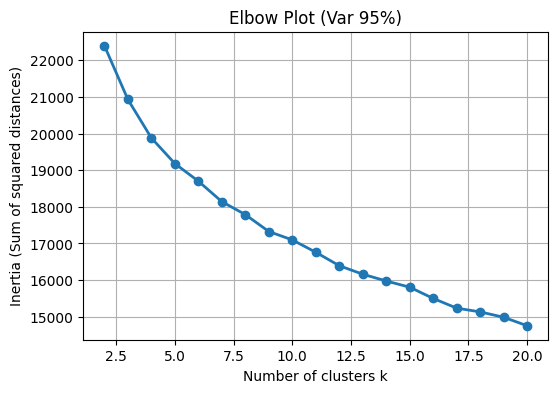

Best k for silhouette: 19


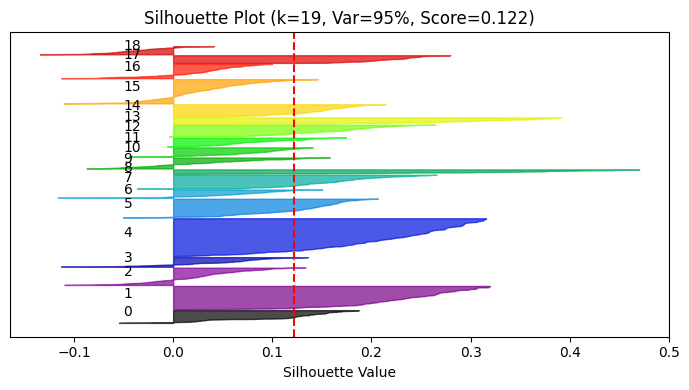

{0.98: 19, 0.95: 19, 0.9: 13, 0.8: 7, 0.5: 6}

Variance threshold: 90%


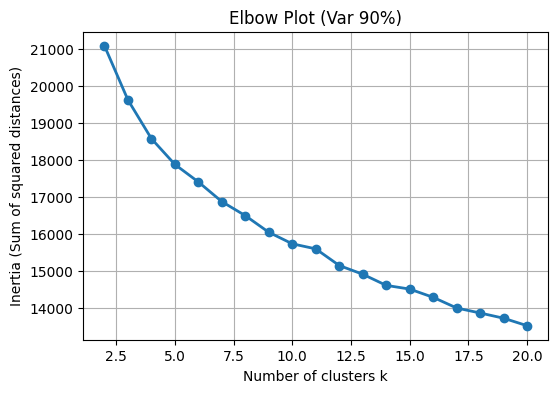

Best k for silhouette: 18


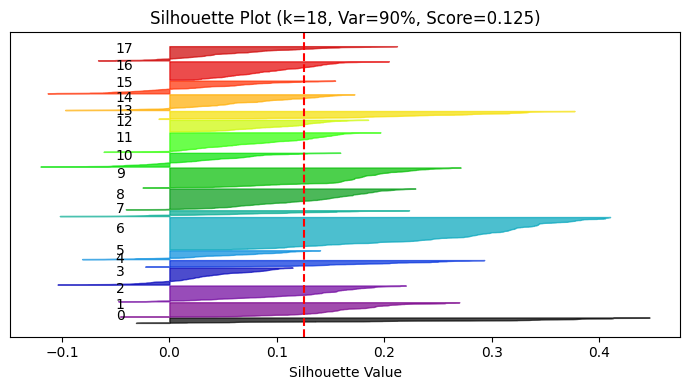

{0.98: 19, 0.95: 19, 0.9: 18, 0.8: 7, 0.5: 6}

Variance threshold: 80%


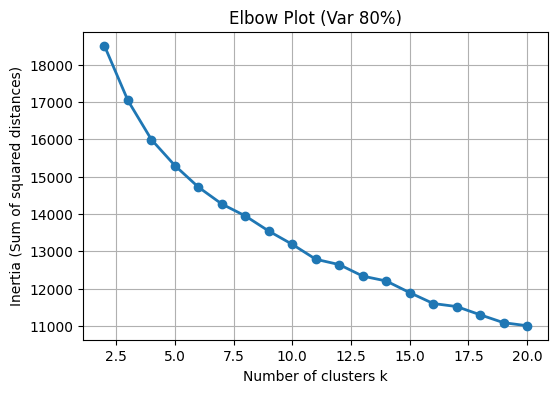

Best k for silhouette: 16


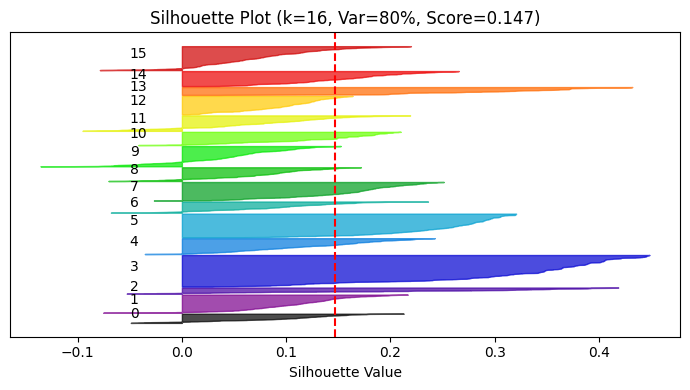

{0.98: 19, 0.95: 19, 0.9: 18, 0.8: 16, 0.5: 6}

Variance threshold: 50%


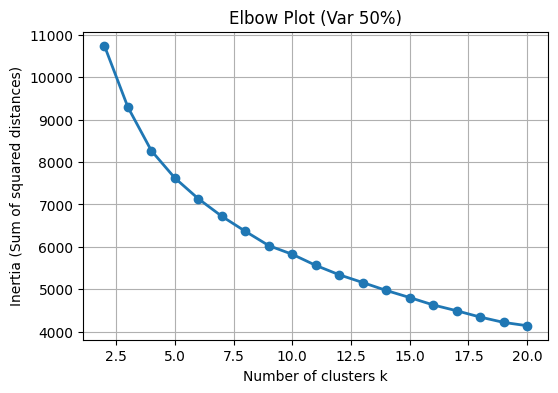

Best k for silhouette: 20


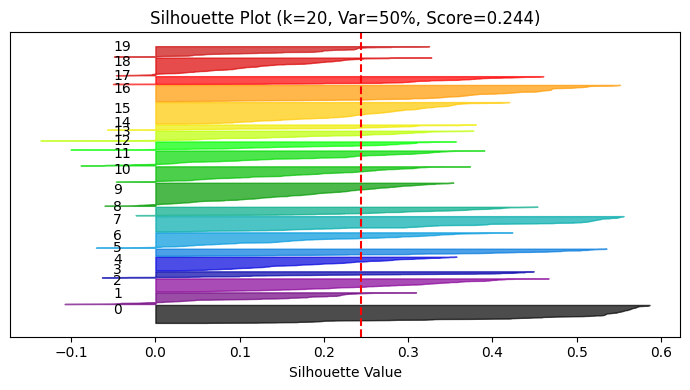

{0.98: 19, 0.95: 19, 0.9: 18, 0.8: 16, 0.5: 20}


In [13]:
elbow_silluette_plot(2, 20)


Variance threshold: 98%


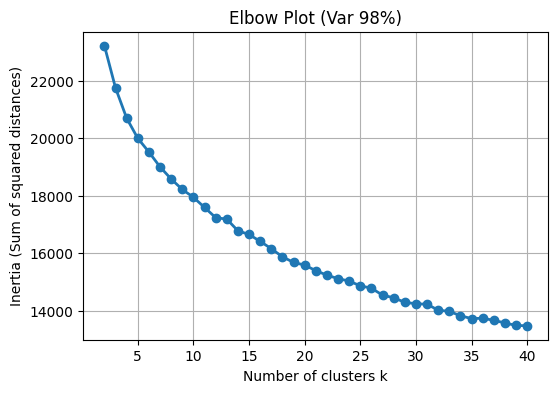

Best k for silhouette: 23


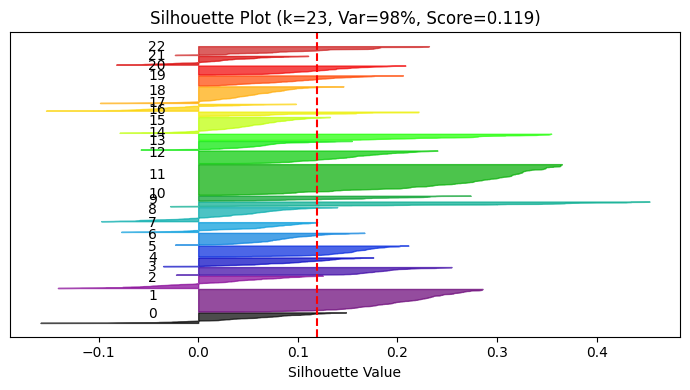

{0.98: 23, 0.95: 19, 0.9: 18, 0.8: 16, 0.5: 20}

Variance threshold: 95%


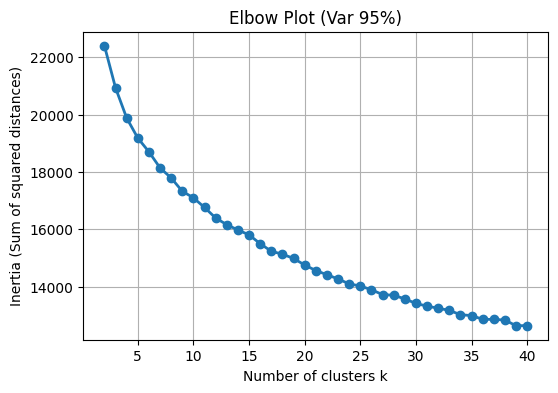

Best k for silhouette: 30


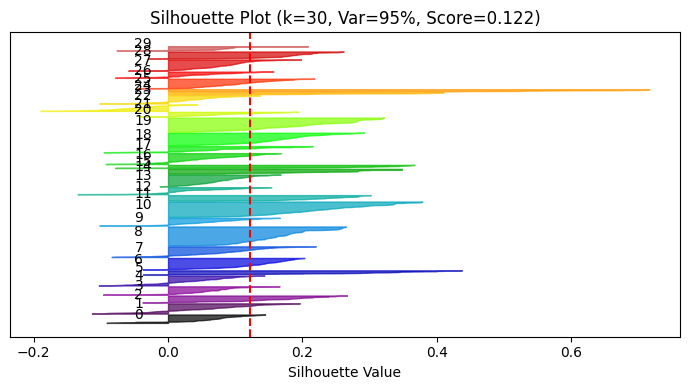

{0.98: 23, 0.95: 30, 0.9: 18, 0.8: 16, 0.5: 20}

Variance threshold: 90%


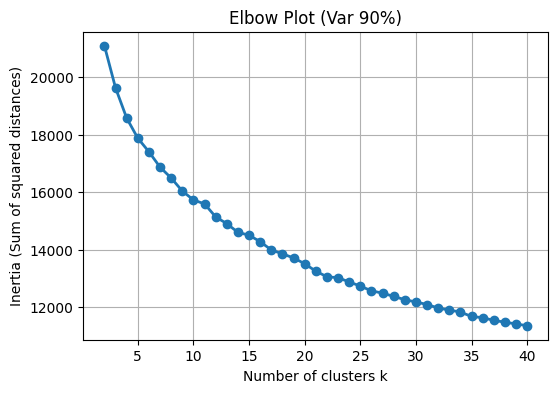

Best k for silhouette: 28


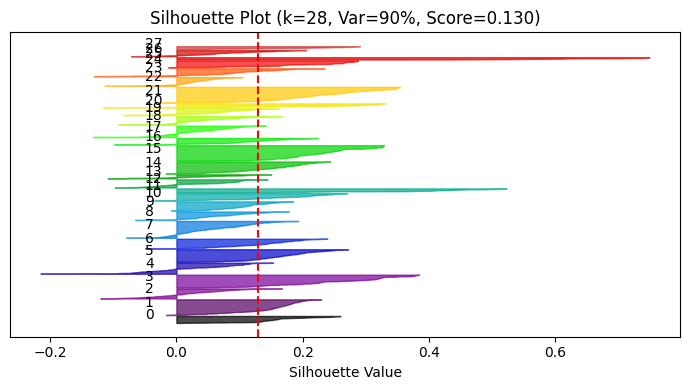

{0.98: 23, 0.95: 30, 0.9: 28, 0.8: 16, 0.5: 20}

Variance threshold: 80%


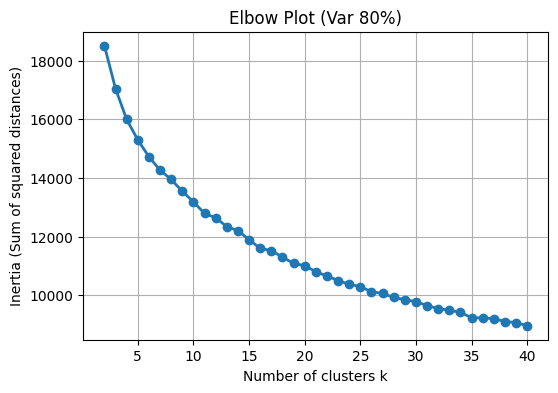

Best k for silhouette: 39


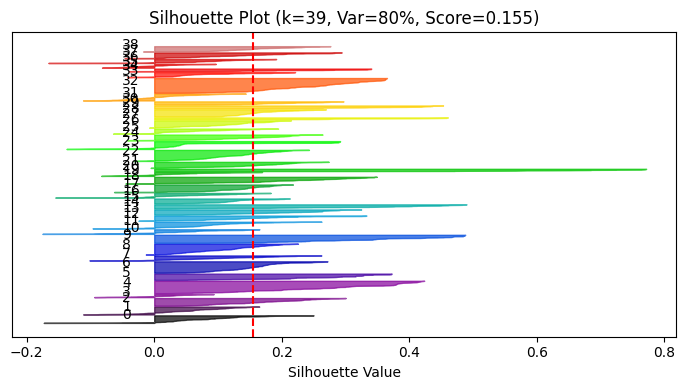

{0.98: 23, 0.95: 30, 0.9: 28, 0.8: 39, 0.5: 20}

Variance threshold: 50%


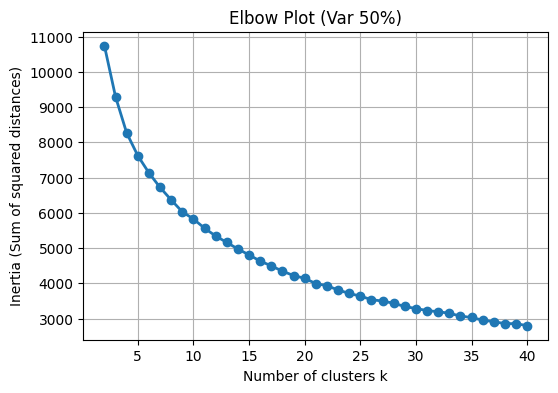

Best k for silhouette: 40


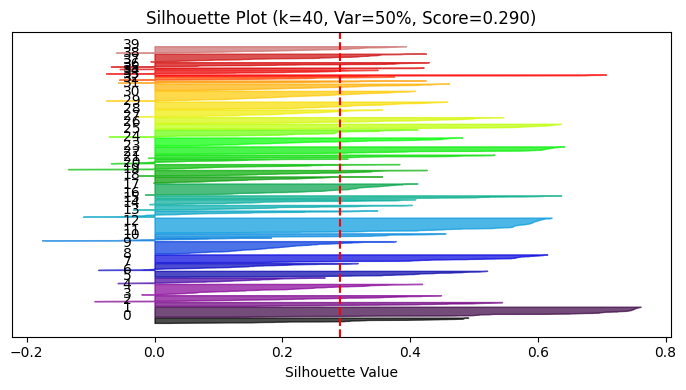

{0.98: 23, 0.95: 30, 0.9: 28, 0.8: 39, 0.5: 40}


In [14]:
elbow_silluette_plot(2, 40)

In [15]:
# elbow_silluette_plot(2, 102) Dureaza mult si nu cred ca are prea mult sense sau rost

In [16]:

def create_scatter_plots(best_k_for_variance= best_k_for_variance):
    var_thresholds = [0.98, 0.95, 0.90, 0.80, 0.50]

    for var_thresh in var_thresholds:
        print(f"\n Scatter plot for PCA variance {int(var_thresh*100)}%")

        pca = PCA(n_components=var_thresh, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        

        best_k = best_k_for_variance[var_thresh]
        
        km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        cluster_labels = km.fit_predict(X_pca)
        
        plt.figure(figsize=(8,6))
        palette = sns.color_palette("tab20", best_k)
        for cluster in range(best_k):
            plt.scatter(
                X_pca[cluster_labels == cluster, 0],
                X_pca[cluster_labels == cluster, 1],
                s=30, alpha=0.7,
                label=f'Cluster {cluster}',
                color=palette[cluster % 20]
            )
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.title(f"PCA Scatter Plot (Var {int(var_thresh*100)}%, k={best_k})")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


 Scatter plot for PCA variance 98%


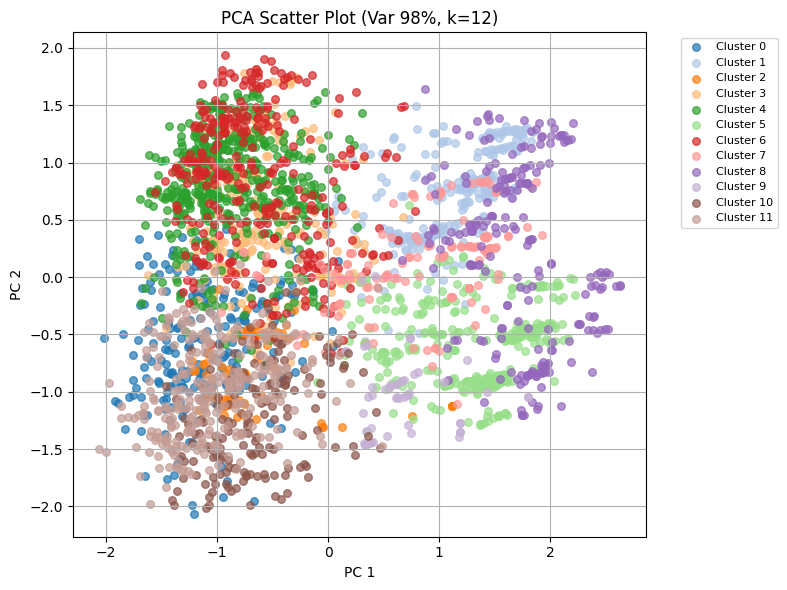


 Scatter plot for PCA variance 95%


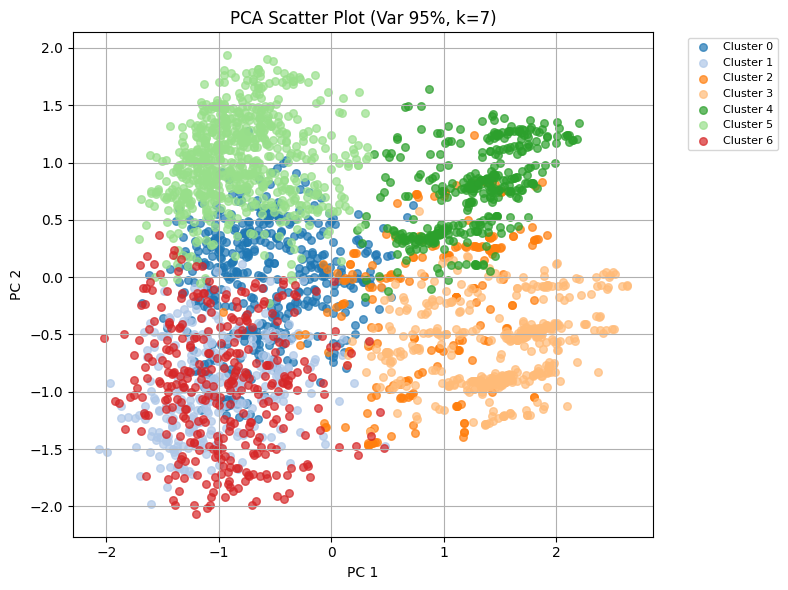


 Scatter plot for PCA variance 90%


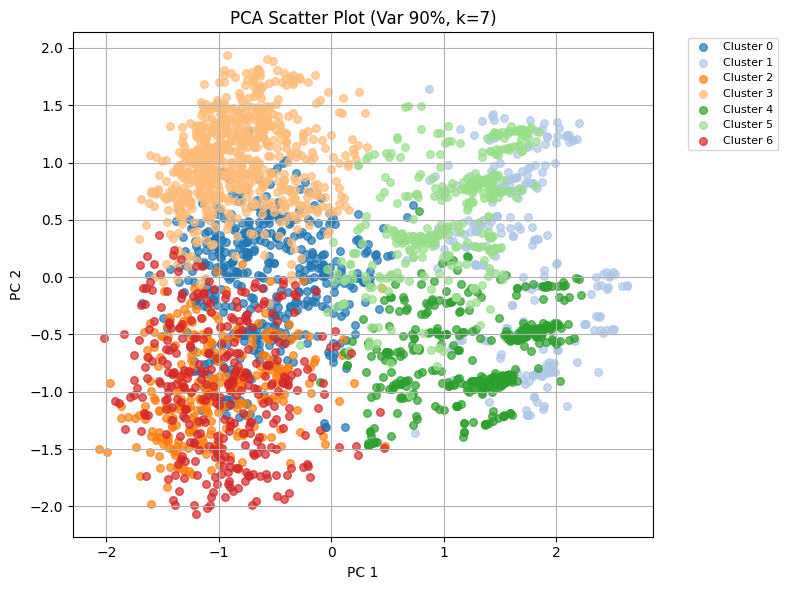


 Scatter plot for PCA variance 80%


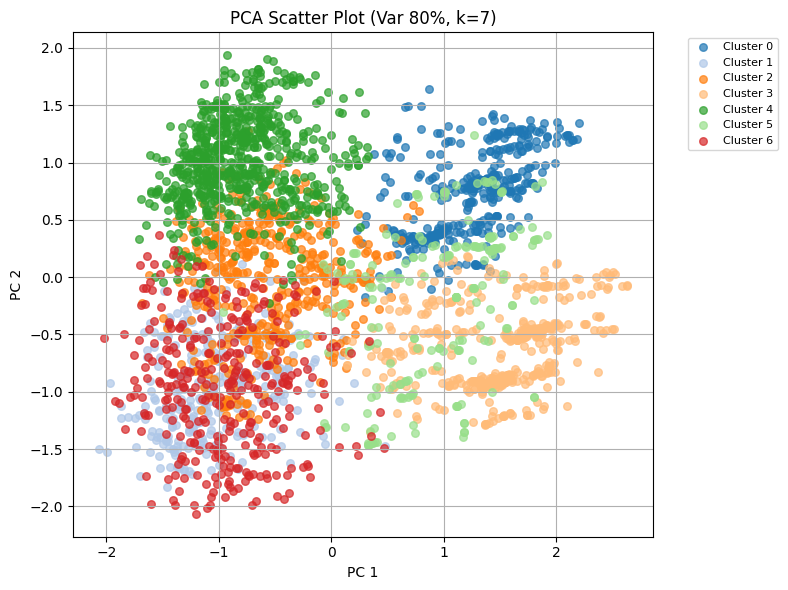


 Scatter plot for PCA variance 50%


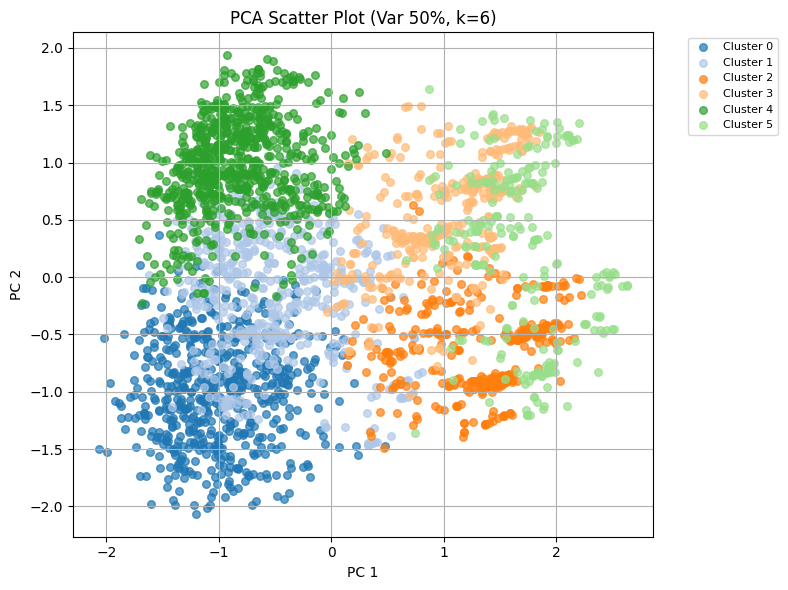

In [17]:
best_k_for_variance[0.98] = 12
best_k_for_variance[0.95] = 7
best_k_for_variance[0.90] = 7
best_k_for_variance[0.80] = 7
best_k_for_variance[0.50] = 6
create_scatter_plots(best_k_for_variance)


 Scatter plot for PCA variance 98%


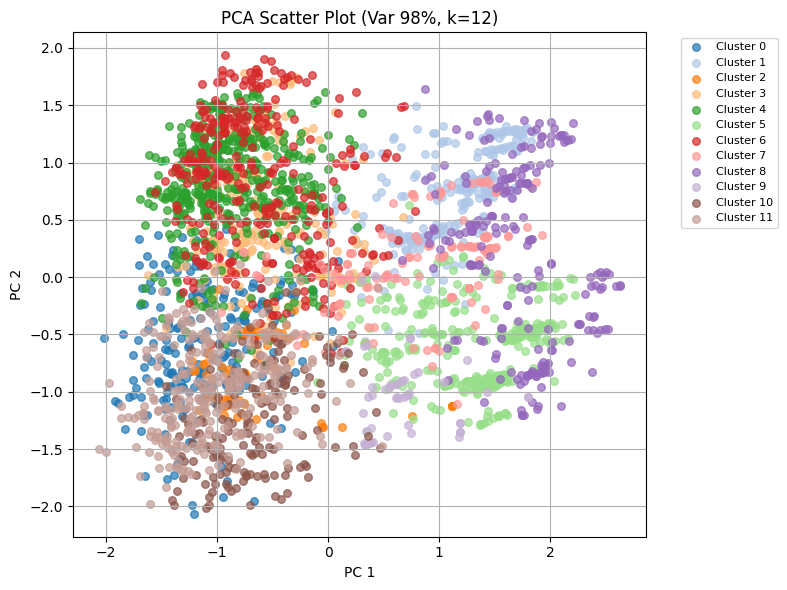


 Scatter plot for PCA variance 95%


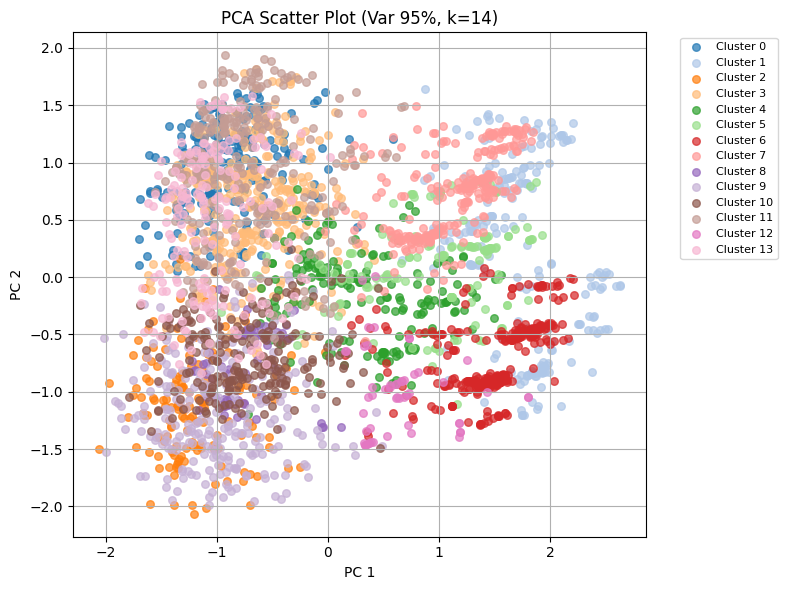


 Scatter plot for PCA variance 90%


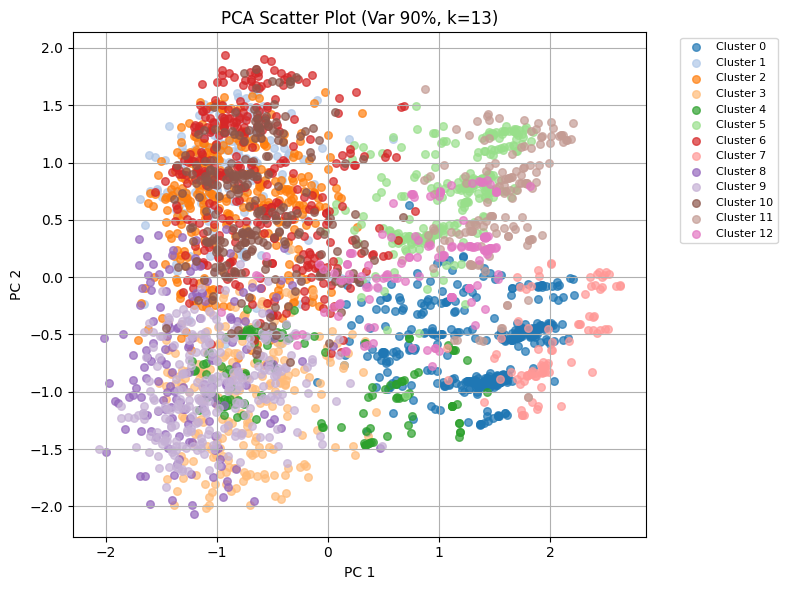


 Scatter plot for PCA variance 80%


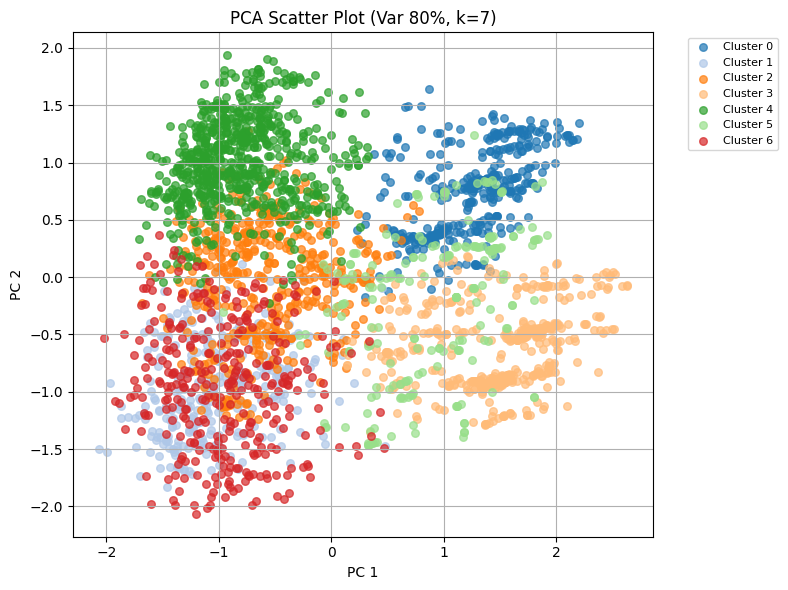


 Scatter plot for PCA variance 50%


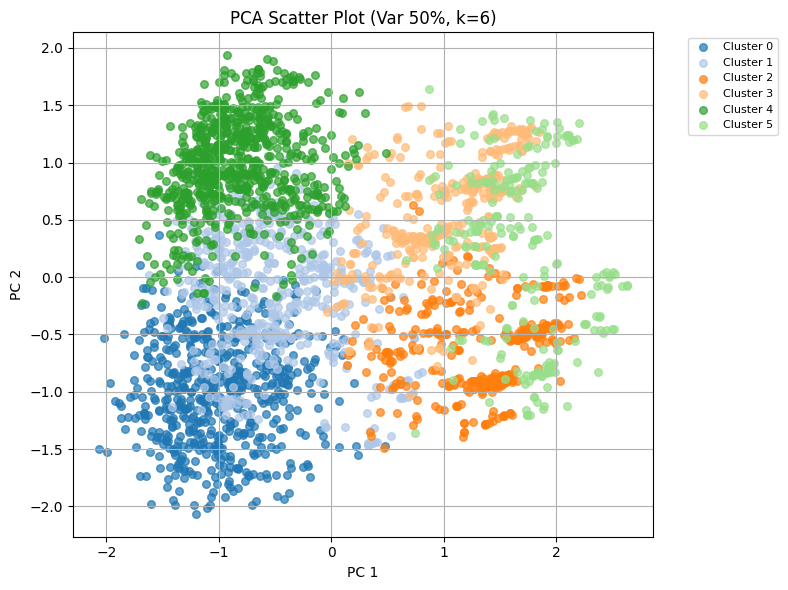

In [18]:
best_k_for_variance[0.98] = 12
best_k_for_variance[0.95] = 14
best_k_for_variance[0.90] = 13
best_k_for_variance[0.80] = 7
best_k_for_variance[0.50] = 6
create_scatter_plots(best_k_for_variance)

Top 15 Features influencing PC1 and PC2:
                           PC1       PC2  Total_abs
Foundation_CBlock    -0.308238  0.189631   0.497869
Foundation_PConc      0.416198 -0.050567   0.466764
House Style_2Story    0.182945 -0.243950   0.426895
House Style_1Story   -0.051968  0.373702   0.425671
Mas Vnr Type_nan     -0.204030 -0.202044   0.406074
MS SubClass_20       -0.025066  0.379329   0.404395
Exterior 1st_VinylSd  0.363740 -0.026184   0.389925
Exterior 2nd_VinylSd  0.360790 -0.026699   0.387489
MS SubClass_60        0.217585 -0.121458   0.339042
MS Zoning_RL          0.077739  0.230986   0.308725
Heating QC           -0.276201  0.030690   0.306891
MS Zoning_RM         -0.108093 -0.180359   0.288452
Mas Vnr Type_BrkFace  0.125736  0.157167   0.282902
Year Remod/Add        0.253468  0.008206   0.261674
Neighborhood_NAmes   -0.116586  0.128636   0.245222


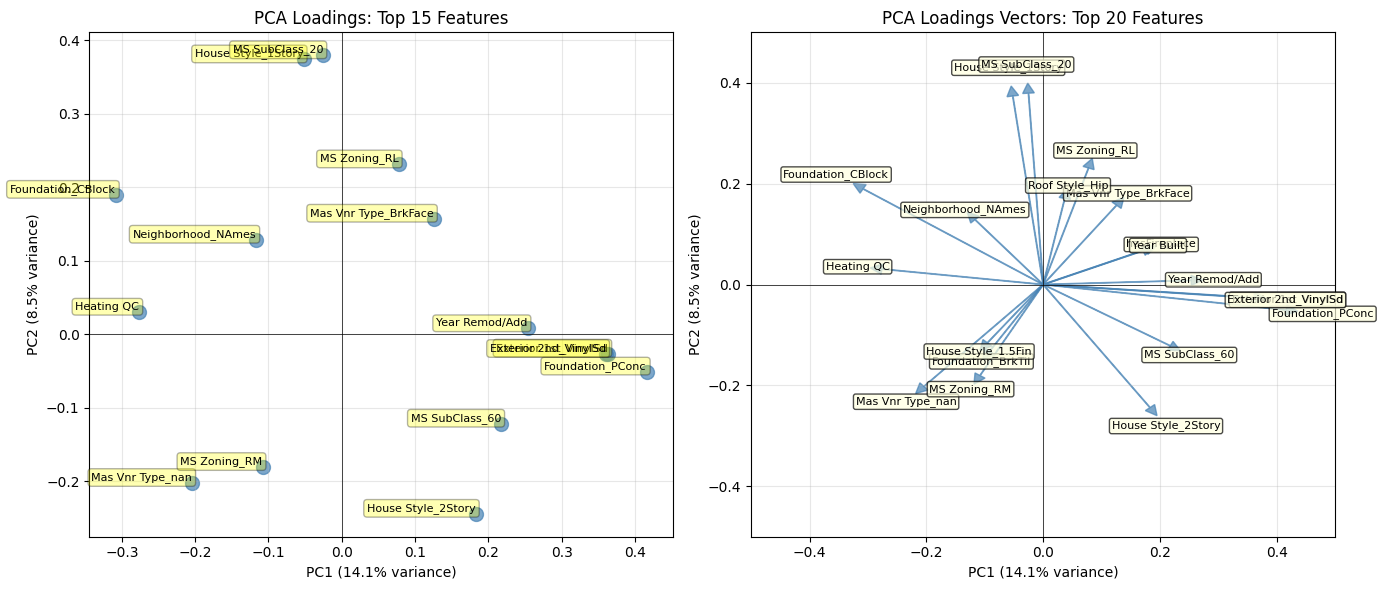

In [25]:
pca_full_load = PCA(n_components=0.95, random_state=42)
X_pca_full = pca_full_load.fit_transform(X_scaled)

loadings = pca_full_load.components_.T * np.sqrt(pca_full_load.explained_variance_)

loadings_df = pd.DataFrame(
    loadings[:, :2],
    columns=['PC1', 'PC2'],
    index=X_scaled.columns
)

loadings_df['PC1_abs'] = np.abs(loadings_df['PC1'])
loadings_df['PC2_abs'] = np.abs(loadings_df['PC2'])
loadings_df['Total_abs'] = loadings_df['PC1_abs'] + loadings_df['PC2_abs']

print("Top 15 Features influencing PC1 and PC2:")
print(loadings_df.nlargest(15, 'Total_abs')[['PC1', 'PC2', 'Total_abs']])


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

top_n = 15
top_features_idx = loadings_df['Total_abs'].nlargest(top_n).index
top_loadings = loadings_df.loc[top_features_idx, ['PC1', 'PC2']]

ax = axes[0]
ax.scatter(top_loadings['PC1'], top_loadings['PC2'], s=100, alpha=0.7, color='steelblue')
for idx, (feature, row) in enumerate(top_loadings.iterrows()):
    ax.annotate(feature, (row['PC1'], row['PC2']), 
                fontsize=8, ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_full_load.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca_full_load.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA Loadings: Top 15 Features')
ax.grid(True, alpha=0.3)

ax = axes[1]
top_20_idx = loadings_df['Total_abs'].nlargest(20).index
vectors = loadings_df.loc[top_20_idx, ['PC1', 'PC2']]

for feature, row in vectors.iterrows():
    ax.arrow(0, 0, row['PC1'], row['PC2'], 
             head_width=0.02, head_length=0.02, fc='steelblue', ec='steelblue', alpha=0.7)
    ax.text(row['PC1']*1.15, row['PC2']*1.15, feature, 
            fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow', alpha=0.7))

ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_full_load.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca_full_load.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA Loadings Vectors: Top 20 Features')
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()


In [27]:
best_k = best_k_for_variance[0.95]

pca_95 = PCA(n_components=0.95, random_state=42)
X_pca_95 = pca_95.fit_transform(X_scaled)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_pca_95)

for cluster_id in range(best_k):
    print(f" Cluster {cluster_id}: {np.sum(cluster_labels == cluster_id)} houses")

analysis_df = new_df.copy()
analysis_df['Cluster'] = cluster_labels

key_features = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'TotalSF', 'TotalBath', 
                'Garage Area', 'Garage Cars', 'hasBasement', 'hasGarage', 'hasFireplace']

key_features = [f for f in key_features if f in analysis_df.columns]

print("Average Values per Cluster:")
cluster_profiles = analysis_df.groupby('Cluster')[key_features].mean()
print(cluster_profiles)


 Cluster 0: 206 houses
 Cluster 1: 205 houses
 Cluster 2: 150 houses
 Cluster 3: 331 houses
 Cluster 4: 179 houses
 Cluster 5: 162 houses
 Cluster 6: 359 houses
 Cluster 7: 269 houses
 Cluster 8: 87 houses
 Cluster 9: 250 houses
 Cluster 10: 208 houses
 Cluster 11: 284 houses
 Cluster 12: 53 houses
 Cluster 13: 186 houses
Average Values per Cluster:
             SalePrice  Overall Qual  Gr Liv Area      TotalSF  TotalBath  \
Cluster                                                                     
0        152007.601942      5.446602  1315.014563  2400.174757   1.849515   
1        282863.253659      7.736585  1858.346341  3309.190244   2.704878   
2        115965.493333      4.906667  1309.660000  2115.240000   1.590000   
3        150150.117825      5.347432  1280.903323  2322.978852   2.092145   
4        224350.480447      6.620112  2044.614525  3021.603352   2.818436   
5        214845.253086      7.240741  1381.895062  2702.827160   2.574074   
6        228130.320334      7.03

In [31]:

print("Deviation from Overall Mean:")
overall_mean = analysis_df[key_features].mean()
deviation_df = cluster_profiles - overall_mean
print(deviation_df)



Deviation from Overall Mean:
             SalePrice  Overall Qual  Gr Liv Area     TotalSF  TotalBath  \
Cluster                                                                    
0        -28792.997580     -0.648652  -184.711965 -151.035212  -0.368307   
1        102062.654137      1.641331   358.619814  757.980275   0.487056   
2        -64835.106189     -1.188588  -190.066528 -435.969969  -0.627822   
3        -30650.481697     -0.747822  -218.823205 -228.231117  -0.125677   
4         43549.880925      0.524857   544.887997  470.393383   0.600614   
5         34044.653564      1.145486  -117.831466  151.617191   0.356252   
6         47329.720812      0.940957   394.914141  319.606187   0.704184   
7         63989.062188      1.176121    50.611762  542.626462   0.304483   
8        -70248.415614     -0.807898  -336.197792 -769.416866  -0.292534   
9        -60772.659522     -0.839254  -107.862528 -401.305969  -0.661822   
10       -24060.676445     -0.499101    87.826357 -132.0417

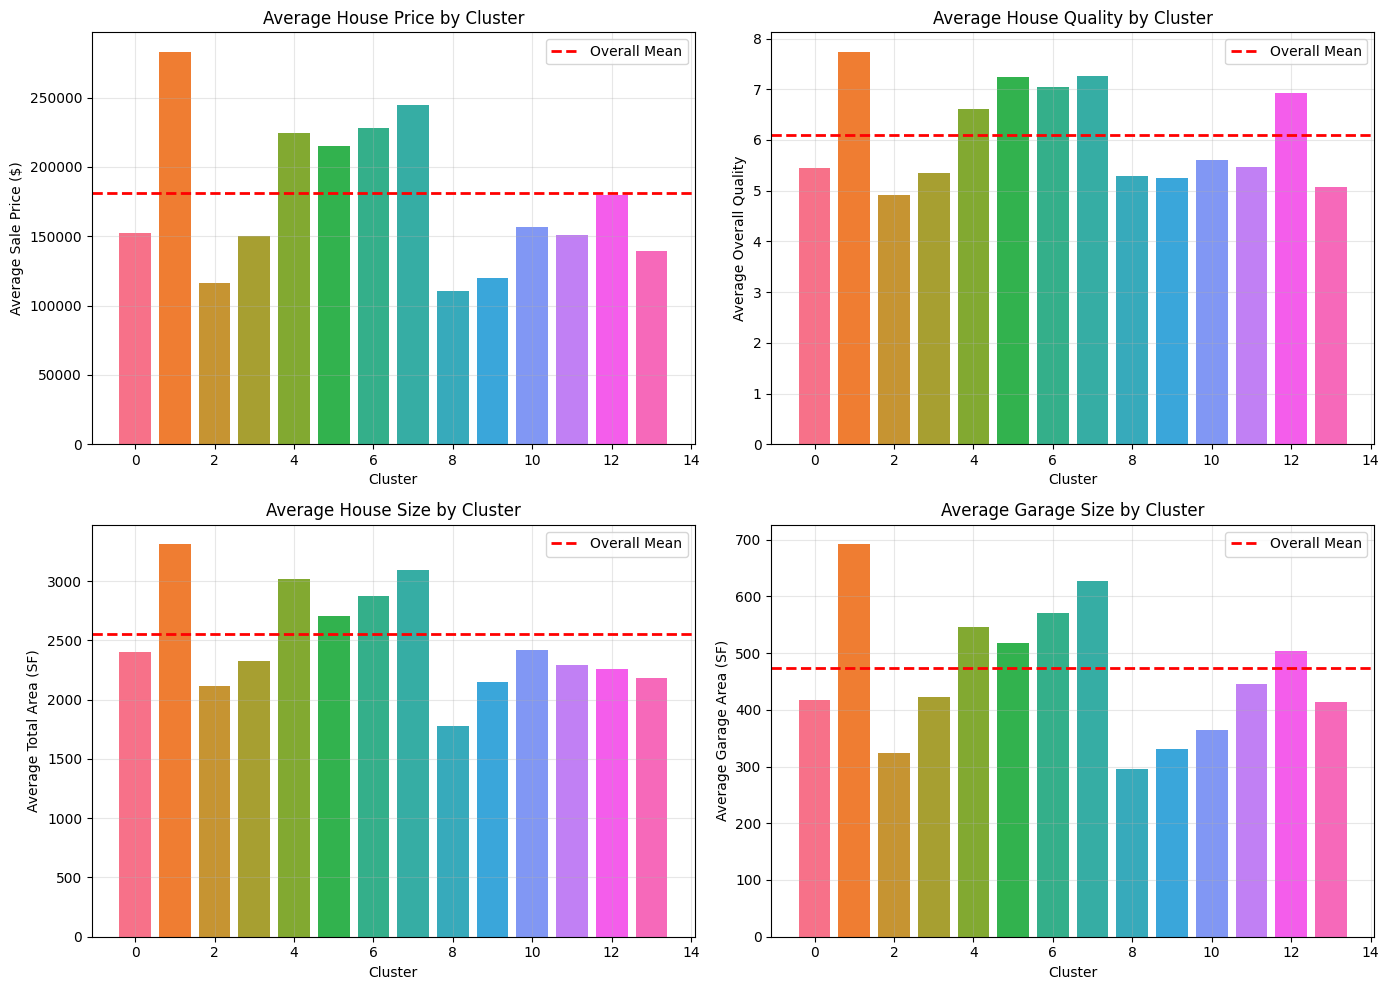

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
cluster_prices = analysis_df.groupby('Cluster')['SalePrice'].mean()
colors = sns.color_palette("husl", best_k)
ax.bar(cluster_prices.index, cluster_prices.values, color=colors)
ax.axhline(y=analysis_df['SalePrice'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
ax.set_xlabel('Cluster')
ax.set_ylabel('Average Sale Price ($)')
ax.set_title('Average House Price by Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
cluster_quality = analysis_df.groupby('Cluster')['Overall Qual'].mean()
ax.bar(cluster_quality.index, cluster_quality.values, color=colors)
ax.axhline(y=analysis_df['Overall Qual'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
ax.set_xlabel('Cluster')
ax.set_ylabel('Average Overall Quality')
ax.set_title('Average House Quality by Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
cluster_size = analysis_df.groupby('Cluster')['TotalSF'].mean()
ax.bar(cluster_size.index, cluster_size.values, color=colors)
ax.axhline(y=analysis_df['TotalSF'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
ax.set_xlabel('Cluster')
ax.set_ylabel('Average Total Area (SF)')
ax.set_title('Average House Size by Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
cluster_garage = analysis_df.groupby('Cluster')['Garage Area'].mean()
ax.bar(cluster_garage.index, cluster_garage.values, color=colors)
ax.axhline(y=analysis_df['Garage Area'].mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
ax.set_xlabel('Cluster')
ax.set_ylabel('Average Garage Area (SF)')
ax.set_title('Average Garage Size by Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [33]:
for cluster_id in range(best_k):
    cluster_data = analysis_df[analysis_df['Cluster'] == cluster_id]
    print(f"\n CLUSTER {cluster_id} ({len(cluster_data)} houses):")
    print(f"Avg Price: ${cluster_data['SalePrice'].mean():,.0f}")
    print(f"Avg Quality: {cluster_data['Overall Qual'].mean():.1f}/10")
    print(f"Avg Size: {cluster_data['TotalSF'].mean():.0f} SF")
    print(f"Avg Bathrooms: {cluster_data['TotalBath'].mean():.1f}")
    print(f"Avg Garage Size: {cluster_data['Garage Area'].mean():.0f} SF")
    print(f"Has Garage: {(cluster_data['hasGarage'].sum() / len(cluster_data) * 100):.1f}%")
    print(f"Has Basement: {(cluster_data['hasBasement'].sum() / len(cluster_data) * 100):.1f}%")
    print(f"Has Fireplace: {(cluster_data['hasFireplace'].sum() / len(cluster_data) * 100):.1f}%")


 CLUSTER 0 (206 houses):
Avg Price: $152,008
Avg Quality: 5.4/10
Avg Size: 2400 SF
Avg Bathrooms: 1.8
Avg Garage Size: 417 SF
Has Garage: 97.6%
Has Basement: 93.2%
Has Fireplace: 54.9%

 CLUSTER 1 (205 houses):
Avg Price: $282,863
Avg Quality: 7.7/10
Avg Size: 3309 SF
Avg Bathrooms: 2.7
Avg Garage Size: 691 SF
Has Garage: 98.5%
Has Basement: 100.0%
Has Fireplace: 66.3%

 CLUSTER 2 (150 houses):
Avg Price: $115,965
Avg Quality: 4.9/10
Avg Size: 2115 SF
Avg Bathrooms: 1.6
Avg Garage Size: 323 SF
Has Garage: 88.0%
Has Basement: 96.7%
Has Fireplace: 20.0%

 CLUSTER 3 (331 houses):
Avg Price: $150,150
Avg Quality: 5.3/10
Avg Size: 2323 SF
Avg Bathrooms: 2.1
Avg Garage Size: 422 SF
Has Garage: 90.3%
Has Basement: 92.1%
Has Fireplace: 45.0%

 CLUSTER 4 (179 houses):
Avg Price: $224,350
Avg Quality: 6.6/10
Avg Size: 3022 SF
Avg Bathrooms: 2.8
Avg Garage Size: 546 SF
Has Garage: 100.0%
Has Basement: 98.9%
Has Fireplace: 83.8%

 CLUSTER 5 (162 houses):
Avg Price: $214,845
Avg Quality: 7.2/10
Av

In [34]:
print(new_df.describe())

       MS SubClass  Lot Frontage      Lot Area  Overall Qual  Overall Cond  \
count  2929.000000   2439.000000    2929.00000   2929.000000   2929.000000   
mean     57.379652     69.223042   10148.06282      6.095254      5.563332   
std      42.643257     23.370001    7881.35958      1.411122      1.111678   
min      20.000000     21.000000    1300.00000      1.000000      1.000000   
25%      20.000000     58.000000    7440.00000      5.000000      5.000000   
50%      50.000000     68.000000    9434.00000      6.000000      5.000000   
75%      70.000000     80.000000   11556.00000      7.000000      6.000000   
max     190.000000    313.000000  215245.00000     10.000000      9.000000   

        Year Built  Year Remod/Add  Mas Vnr Area  Gr Liv Area    Full Bath  \
count  2929.000000     2929.000000   2906.000000  2929.000000  2929.000000   
mean   1971.344486     1984.258791    101.931865  1499.726528     1.566405   
std      30.243747       20.859616    179.133457   505.591429  

In [49]:
print(f"SalePrice: {new_df['SalePrice'].min():,.0f} to {new_df['SalePrice'].max():,.0f}")
print(f"Lot Frontage: {new_df['Lot Frontage'].min():.0f} to {new_df['Lot Frontage'].max():.0f}")
print(f"Living Area: {new_df['Gr Liv Area'].min():.0f} to {new_df['Gr Liv Area'].max():.0f}")
print(f"Overall Qual: {new_df['Overall Qual'].min()} to {new_df['Overall Qual'].max()}")

luxury_indices = analysis_df[analysis_df['Cluster'] == 1].index
budget_indices = analysis_df[analysis_df['Cluster'] == 8].index
midrange_indices = analysis_df[analysis_df['Cluster'] == 12].index

luxury_idx = analysis_df.loc[luxury_indices, 'SalePrice'].idxmax()
budget_idx = analysis_df.loc[budget_indices, 'SalePrice'].idxmin()
midrange_idx = analysis_df.loc[midrange_indices, 'Overall Qual'].idxmax()

top_pca_features = loadings_df['Total_abs'].nlargest(5).index.tolist()
print("Top 5 PCA features influencing PC1/PC2:", top_pca_features)

synthetic_houses_data = []

# Luxury House
house_a = X_scaled.loc[luxury_idx].copy()
house_a[house_a.index.str.contains('Overall Qual', case=False)] = 0.95
house_a[house_a.index.str.contains('Gr Liv Area', case=False)] = 0.90
house_a[house_a.index.str.contains('Garage', case=False)] = 0.85
for f in top_pca_features:
    if f in house_a.index:
        house_a[f] = min(1.0, house_a[f] + 0.2)
synthetic_houses_data.append(('House A: Luxury Home', house_a))

# Budget House
house_b = X_scaled.loc[budget_idx].copy()
house_b[house_b.index.str.contains('Overall Qual', case=False)] = 0.20
house_b[house_b.index.str.contains('Gr Liv Area', case=False)] = 0.20
house_b[house_b.index.str.contains('Garage', case=False)] = 0.20
for f in top_pca_features:
    if f in house_b.index:
        house_b[f] = max(0.0, house_b[f] - 0.2)
synthetic_houses_data.append(('House B: Budget Home', house_b))

# Mid-range House
house_c = X_scaled.loc[midrange_idx].copy()
for f in top_pca_features:
    if f in house_c.index:
        house_c[f] = house_c[f]
synthetic_houses_data.append(('House C: Mid-range Home', house_c))

house_d = X_scaled.loc[midrange_idx].copy()
for f in top_pca_features:
    if f in house_d.index:
        house_d[f] = house_d[f] * 1.05
synthetic_houses_data.append(('House D: Mid-range Home 2', house_d))

synthetic_scaled_df = pd.DataFrame([h[1] for h in synthetic_houses_data], columns=X_scaled.columns)
synthetic_labels_list = [h[0] for h in synthetic_houses_data]

synthetic_pca = pca_95.transform(synthetic_scaled_df)
synthetic_clusters = kmeans_final.predict(synthetic_pca)

compare_features = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'TotalSF', 
                    'TotalBath', 'Garage Area', 'Garage Cars'] 


for name, cid, orig_idx in zip(synthetic_labels_list, synthetic_clusters, 
                               [luxury_idx, budget_idx, midrange_idx, midrange_idx]):
    print(f"\n{name}")
    print(f"Predicted cluster: {cid}")

    cluster_data = analysis_df[analysis_df['Cluster'] == cid]
    cluster_mean = cluster_data[compare_features].mean()
    synthetic_values = new_df.loc[orig_idx, compare_features]

    comparison_df = pd.DataFrame({
        'Synthetic House': synthetic_values,
        'Cluster Average': cluster_mean
    })

    print(comparison_df)


SalePrice: 12,789 to 755,000
Lot Frontage: 21 to 313
Living Area: 334 to 5642
Overall Qual: 1 to 10
Top 5 PCA features influencing PC1/PC2: ['Foundation_CBlock', 'Foundation_PConc', 'House Style_2Story', 'House Style_1Story', 'Mas Vnr Type_nan']

House A: Luxury Home
Predicted cluster: 1
             Synthetic House  Cluster Average
SalePrice             611657    282863.253659
Overall Qual               9         7.736585
Gr Liv Area             2364      1858.346341
TotalSF               4694.0      3309.190244
TotalBath                3.5         2.704878
Garage Area            820.0       691.492683
Garage Cars              3.0         2.507317

House B: Budget Home
Predicted cluster: 3
             Synthetic House  Cluster Average
SalePrice              71000    150150.117825
Overall Qual               4         5.347432
Gr Liv Area             1092      1280.903323
TotalSF               1638.0      2322.978852
TotalBath                1.5         2.092145
Garage Area            2

In [53]:
import plotly.graph_objects as go
import plotly.express as px

best_k = best_k_for_variance[0.95]

fig = go.Figure()

colors = px.colors.qualitative.Plotly
cluster_colors = {i: colors[i % len(colors)] for i in range(best_k)}

for cluster_id in range(best_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_data = X_pca_95[cluster_mask]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data[:, 0],
        y=cluster_data[:, 1],
        z=cluster_data[:, 2],
        mode='markers',
        name=f'Cluster {cluster_id}',
        marker=dict(
            size=4,
            color=cluster_colors[cluster_id],
            opacity=0.7,
            symbol='circle'
        ),
        text=[f'Cluster {cluster_id}<br>Point {i}' for i in range(len(cluster_data))],
        hovertemplate='<b>%{text}</b><br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<extra></extra>'
    ))

centroids_pca = kmeans_final.cluster_centers_

for cluster_id in range(best_k):
    centroid = centroids_pca[cluster_id]
    
    fig.add_trace(go.Scatter3d(
        x=[centroid[0]],
        y=[centroid[1]],
        z=[centroid[2]],
        mode='markers',
        name=f'Centroid {cluster_id}',
        marker=dict(
            size=12,
            color=cluster_colors[cluster_id],
            opacity=1.0,
            symbol='diamond',
            line=dict(color='black', width=2)
        ),
        text=[f'Centroid {cluster_id}'],
        hovertemplate='<b>Centroid %{text}</b><br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<extra></extra>',
        showlegend=False
    ))

fig.update_layout(
    title=dict(
        text=f'3D Cluster Visualization - {best_k} Clusters with Centroids<br><sub>First 3 Principal Components</sub>',
        x=0.5,
        xanchor='center'
    ),
    scene=dict(
        xaxis_title=f'PC1 ({pca_95.explained_variance_ratio_[0]:.1%} var)',
        yaxis_title=f'PC2 ({pca_95.explained_variance_ratio_[1]:.1%} var)',
        zaxis_title=f'PC3 ({pca_95.explained_variance_ratio_[2]:.1%} var)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    width=1200,
    height=800,
    hovermode='closest',
    font=dict(size=12),
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )
)

fig.show()


print(f"\nTotal samples: {len(X_pca_95)}")
print(f"Number of clusters: {best_k}")
print(f"PCA variance captured in first 3 components: {pca_95.explained_variance_ratio_[:3].sum():.1%}")
print(f"\nVariance per component:")
print(f"PC1: {pca_95.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca_95.explained_variance_ratio_[1]:.2%}")
print(f"PC3: {pca_95.explained_variance_ratio_[2]:.2%}")

print(f"\nCluster sizes:")
for cluster_id in range(best_k):
    count = np.sum(cluster_labels == cluster_id)
    pct = count / len(cluster_labels) * 100
    print(f"Cluster {cluster_id:2d}: {count:4d} samples ({pct:5.1f}%)")

print(f"\nCentroid coordinates:")
print(f"{'Cluster':<10} {'PC1':>12} {'PC2':>12} {'PC3':>12}")
for cluster_id in range(best_k):
    centroid = centroids_pca[cluster_id]
    print(f"{cluster_id:<10} {centroid[0]:>12.4f} {centroid[1]:>12.4f} {centroid[2]:>12.4f}")


Total samples: 2929
Number of clusters: 14
PCA variance captured in first 3 components: 28.6%

Variance per component:
PC1: 14.06%
PC2: 8.51%
PC3: 5.99%

Cluster sizes:
Cluster  0:  206 samples (  7.0%)
Cluster  1:  205 samples (  7.0%)
Cluster  2:  150 samples (  5.1%)
Cluster  3:  331 samples ( 11.3%)
Cluster  4:  179 samples (  6.1%)
Cluster  5:  162 samples (  5.5%)
Cluster  6:  359 samples ( 12.3%)
Cluster  7:  269 samples (  9.2%)
Cluster  8:   87 samples (  3.0%)
Cluster  9:  250 samples (  8.5%)
Cluster 10:  208 samples (  7.1%)
Cluster 11:  284 samples (  9.7%)
Cluster 12:   53 samples (  1.8%)
Cluster 13:  186 samples (  6.4%)

Centroid coordinates:
Cluster             PC1          PC2          PC3
0               -0.9120       0.9435       0.0932
1                1.7401       0.2155       0.7023
2               -1.1860      -1.1219       0.4978
3               -0.6755       0.5973      -0.0335
4                0.3320      -0.1812      -1.4745
5                0.9799       0